In [44]:
# load help packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # additional plotting functionality

# Input data files are available in the "../input/" directory.
# For example, running the below code (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input/data"))

['images_003', 'images_012', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'images_009', 'images_008', 'images_007', 'test_list.txt', 'images_010', 'ARXIV_V5_CHESTXRAY.pdf', 'images_002', 'images_011', 'Data_Entry_2017.csv', 'images_001', 'train_val_list.txt', 'images_005', 'FAQ_CHESTXRAY.pdf', 'images_004', 'images_006']


In [45]:
# load data
xray_data = pd.read_csv('../input/data/Data_Entry_2017.csv')

# see how many observations there are
num_obs = len(xray_data)
print('Number of observations:',num_obs)

# examine the raw data before performing pre-processing
xray_data.head(5) # view first 5 rows
#xray_data.sample(5) # view 5 randomly sampled rows

Number of observations: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [46]:
from glob import glob
#import os # already imported earlier

my_glob = glob('../input/data/images*/images/*.png')
print('Number of Observations: ', len(my_glob)) # check to make sure I've captured every pathway, should equal 112,120

Number of Observations:  112120


In [58]:
# https://www.kaggle.com/kmader/train-simple-xray-cnn
full_img_paths = {os.path.basename(x): x for x in my_glob}
xray_data['full_path'] = xray_data['Image Index'].map(full_img_paths.get)

In [59]:
dummy_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'] # taken from paper

# One Hot Encoding of Finding Labels to dummy_labels
for label in dummy_labels:
    xray_data[label] = xray_data['Finding Labels'].map(lambda result: 1.0 if label in result else 0)
xray_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,target_vector
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Creation of the model

In [60]:
## MODEL CREATION PHASE STARTS HERE

# create vector as ground-truth, will use as actuals to compare against our predictions later
xray_data['target_vector'] = xray_data.apply(lambda target: [target[dummy_labels].values], 1).map(lambda target: target[0])

In [61]:
xray_data.head() 

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,target_vector
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [62]:
# split the data into a training and testing set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(xray_data, test_size = 0.2, random_state = 1993)

# quick check to see that the training and test set were split properly
print('training set - # of observations: ', len(train_set))
print('test set - # of observations): ', len(test_set))
print('prior, full data set - # of observations): ', len(xray_data))

training set - # of observations:  89696
test set - # of observations):  22424
prior, full data set - # of observations):  112120


In [63]:
# IMAGE PRE-PROCESSING
# See Keras documentation: https://keras.io/preprocessing/image/

# Create ImageDataGenerator, to perform significant image augmentation
# Utilizing most of the parameter options to make the image data even more robust
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

In [68]:
IMG_SIZE = (224, 224)
def flow_from_dataframe(image_generator, dataframe, batch_size):

    df_gen = image_generator.flow_from_dataframe(dataframe,
                                                 x_col='Path',
                                                 y_col=dummy_labels,
                                                 target_size=IMG_SIZE,
                                                 classes=dummy_labels,
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 shuffle=False,
                                                 batch_size=batch_size)
    
    return df_gen

In [69]:
train_gen = flow_from_dataframe(image_generator=base_generator, 
                                dataframe= train_df,
                                batch_size = 32)

valid_gen = flow_from_dataframe(image_generator=base_generator, 
                                dataframe=valid_df,
                                batch_size = 32)

test_gen = flow_from_dataframe(image_generator=base_generator, 
                               dataframe=test_df,
                               batch_size = 32)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 54938 validated image filenames.
Found 23546 validated image filenames.
Found 33636 validated image filenames.


In [70]:
# define test sets
test_X, test_Y = next(train_gen)

In [71]:
## On to the fun stuff! Create a convolutional neural network model to train from scratch

# Import relevant libraries
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Create CNN model
# Will use a combination of convolutional, max pooling, and dropout layers for this purpose
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = test_X.shape[1:]))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
          
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
          
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 3))
model.add(Dropout(0.2))

# add in fully connected dense layers to model, then output classifiction probabilities using a softmax activation function
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(dummy_labels), activation = 'softmax'))

# compile model, run summary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)       

In [72]:
# set up a checkpoint for model training
# https://keras.io/callbacks/
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.best.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only = True)
callbacks_list = [checkpointer]

In [73]:
## Fit the model!
# Note: This first model will be fitted very quickly, will fit a higher accuracy modelthat requires more training time after this
# Documentation: https://keras.io/models/model/
model.fit_generator(generator = train_gen, steps_per_epoch = 20, epochs = 1, callbacks = callbacks_list, validation_data = (test_X, test_Y))

## How I decided which fit function to use
# model.fit_generator() v. model.fit() - https://datascience.stackexchange.com/questions/34444/what-is-the-difference-between-fit-and-fit-generator-in-keras
# 2nd good example: https://medium.com/difference-engine-ai/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2
# Basically, for large data-sets like this one, it's best-practice to use model.fit_generator()
# This is because i) dataset can't be loaded into memory all at once, ii) we're already doing image augmentation, so this solution meshes nicely

20/20 [==============================] - ETA: 0s - loss: 1.8437 - accuracy: 0.1297
Epoch 00001: val_loss improved from inf to 1.14701, saving model to weights.best.01-1.15.hdf5
20/20 [==============================] - 26s 1s/step - loss: 1.8437 - accuracy: 0.1297 - val_loss: 1.1470 - val_accuracy: 0.0625


In [75]:
# Make prediction based on our fitted model
quick_model_predictions = model.predict(test_X, batch_size = 64, verbose = 1)

1/1 [==============================] - 0s 2ms/step


In [76]:
model.fit_generator(generator = train_gen, steps_per_epoch = 50, epochs = 5, callbacks = callbacks_list, validation_data = (test_X, test_Y))

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 19024.4922 - accuracy: 0.1494
Epoch 00001: val_loss did not improve from 1.14701
50/50 [==============================] - 63s 1s/step - loss: 19024.4922 - accuracy: 0.1494 - val_loss: 80688.2969 - val_accuracy: 0.6875
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 14947668.0000 - accuracy: 0.1088
Epoch 00002: val_loss did not improve from 1.14701
50/50 [==============================] - 61s 1s/step - loss: 14947668.0000 - accuracy: 0.1088 - val_loss: 31204600.0000 - val_accuracy: 0.0312
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 671028864.0000 - accuracy: 0.1381
Epoch 00003: val_loss did not improve from 1.14701
50/50 [==============================] - 61s 1s/step - loss: 671028864.0000 - accuracy: 0.1381 - val_loss: 424045568.0000 - val_accuracy: 0.0625
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 8941329408.0000 - accuracy: 0.1275
Epoch 00004: val_loss 

In [77]:
deep_model_predictions = model.predict(test_X, batch_size = 64, verbose = 1)

1/1 [==============================] - 0s 2ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


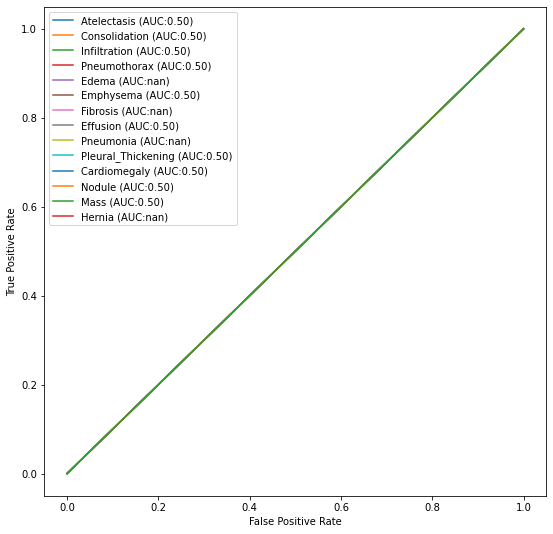

In [78]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt # basic plotting

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (i, label) in enumerate(dummy_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), deep_model_predictions[:,i])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))

# Set labels for plot
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('deep_trained_model.png')